# Neural Machine Translation

Machine translation is a challenging task that traditionally involves large statistical models developed using highly sophisticated linguistic knowledge.

Neural machine translation is the use of deep neural networks for the problem of machine translation.

In this Notebook, you will discover how to develop a neural machine translation system for translating English phrases to Telugu.

Steps:

* Prepare Data
* Preprocess Data
* Text to Sequence Conversion
* Build Encoder-Decoder Model
* Train Model
* Translate English to Telugu

In this Notebook, The [English-Telugu](https://github.com/scionoftech/English_Telugu_Bilingual-Sentence-Pairs) Bilingual-Sentence-Pairs data is used for Neural Machine Translation.

In [1]:
project_path = "/kaggle/working/"

In [2]:
import pandas as pd
import string
from string import digits
import re
import os
from numpy import array, argmax, random, take
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector,TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
# pd.set_option('display.max_colwidth', 200)

2024-07-26 13:53:15.798999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 13:53:15.799120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 13:53:15.918880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Data

In [3]:
# read phrases from english_telugu_data.txt file
english_sentances = []
telugu_sentances = []
with open("/kaggle/input/english-telugu-pairs/english_telugu_data.txt", mode='rt', encoding='utf-8') as fp:
    for line in fp.readlines():
        eng_tel = line.split("++++$++++")
        english_sentances.append(eng_tel[0])
        telugu_sentances.append(eng_tel[1])

In [4]:
data = pd.DataFrame({"english_sentances":english_sentances,"telugu_sentances":telugu_sentances})

In [5]:
data.head()

english_sentances  \
0                                 His legs are long.   
1                Who taught Tom how to speak French?   
2                       I swim in the sea every day.   
3  Tom popped into the supermarket on his way hom...   
4                             Smoke filled the room.   

                                    telugu_sentances  
0                     అతని కాళ్ళు పొడవుగా ఉన్నాయి.\n  
1          టామ్ ఫ్రెంచ్ మాట్లాడటం ఎలా నేర్పించారు?\n  
2            నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను.\n  
3  టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్పుడ...  
4                              పొగ గదిని నింపింది.\n

In [6]:
data.shape

(155798, 2)

In [7]:
# Let's take 70000 phrases from data
data = data.iloc[:70000,:]

## Text Pre-Processing

#### Text Cleaning

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
# clean english sentances
def clean_eng(text):
    # Lowercase all characters
    text = text.lower()
    # map contractions
    text = ' '.join([contraction_mapping[w] if w in contraction_mapping else w for w in text.split(" ")])
    # Remove quotes
    text = re.sub("'", '', text)
    # Remove all the special characters
    exclude = set(string.punctuation) # Set of all special characters
    text = ''.join([c for c in text if c not in exclude])
    # Remove all numbers from text
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    # Remove extra spaces
    text= text.strip()

    return text

In [10]:
# clean telugu sentances
def clean_tel(text):
    # Lowercase all characters
    text = text.lower()
    # Remove quotes
    text = re.sub("'", '', text)
    # Remove all the special characters
    exclude = set(string.punctuation) # Set of all special characters
    text = ''.join([c for c in text if c not in exclude])
    # Remove all numbers from text
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    # Remove Telugu numbers from text
    text = re.sub("[౦౧౨౩౪౫౬౭౮౯]", '', text)
    # Remove extra spaces
    text= text.strip()

    return text

In [11]:
# clean text
data_df = data.copy()
data_df["english_sentances"] = data_df["english_sentances"] .apply(lambda x: clean_eng(x))
data_df["telugu_sentances"] = data_df["telugu_sentances"] .apply(lambda x: clean_tel(x))

In [12]:
data_df.head()

english_sentances  \
0                                  his legs are long   
1                 who taught tom how to speak french   
2                        i swim in the sea every day   
3  tom popped into the supermarket on his way hom...   
4                              smoke filled the room   

                                    telugu_sentances  
0                        అతని కాళ్ళు పొడవుగా ఉన్నాయి  
1             టామ్ ఫ్రెంచ్ మాట్లాడటం ఎలా నేర్పించారు  
2               నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను  
3  టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్పుడ...  
4                                 పొగ గదిని నింపింది

#### Text to Sequence Conversion

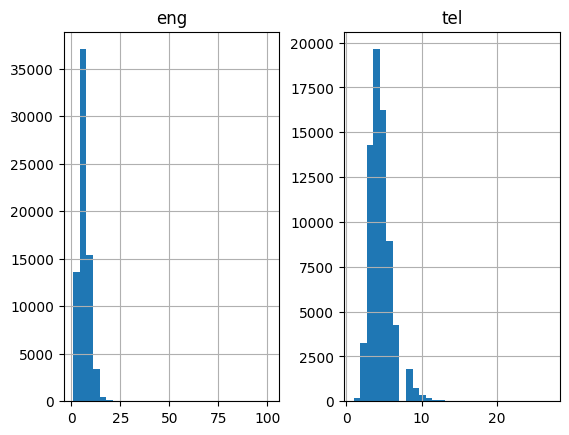

In [13]:
# empty lists
eng_l = []
tel_l = []

# populate the lists with sentence lengths
for i in data_df["english_sentances"].values:
      eng_l.append(len(i.split()))

for i in data_df["telugu_sentances"].values:
      tel_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'tel':tel_l})

length_df.hist(bins = 30)
plt.show()

Quite intuitive – the maximum length of the Telugu sentences is 26 and that of the English phrases is 43.

Next, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.

Note that we will prepare tokenizers for both the Telugu and English sentences:

In [14]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# prepare english tokenizer
eng_tokenizer = tokenization(data_df["english_sentances"])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 43
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 10315


In [16]:
# prepare Telugu tokenizer
tel_tokenizer = tokenization(data_df["telugu_sentances"])
tel_vocab_size = len(tel_tokenizer.word_index) + 1

tel_length = 26
print('Telugu Vocabulary Size: %d' % tel_vocab_size)

Telugu Vocabulary Size: 26680


The below code block contains a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.

In [17]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

We will now split the data into train and test set for model training and evaluation, respectively.

In [18]:
# split data into train and test set
train, test = train_test_split(data_df, test_size=0.2, random_state = 12)

It’s time to encode the sentences. We will encode **English sentences as the input sequences** and **Telugu sentences as the target sequences**. This has to be done for both the train and test datasets.

In [19]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train["english_sentances"])
trainY = encode_sequences(tel_tokenizer, tel_length, train["telugu_sentances"])

# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test["english_sentances"])
testY = encode_sequences(tel_tokenizer, tel_length, test["telugu_sentances"])

In [20]:
trainX.shape,trainY.shape,testX.shape,testY.shape

((56000, 43), (56000, 26), (14000, 43), (14000, 26))

In [21]:
# data generator, intended to be used in a call to model.fit_generator()
# def data_generator(eng_tokenizer,tel_tokenizer, eng_length,tel_length, eng_data,tel_data):
#     # loop for each sentance
#     while 1:
#         for eng_sentance,tel_sentance in zip(eng_data,tel_data):
#             # integer encode sequences
#             eng_seq = eng_tokenizer.texts_to_sequences(eng_sentance)
#             tel_seq = tel_tokenizer.texts_to_sequences(tel_sentance)
#             # pad sequences with 0 values
#             eng_seq = pad_sequences(eng_seq, maxlen=eng_length, padding='post')
#             tel_seq = pad_sequences(tel_seq, maxlen=tel_length, padding='post')
#             yield eng_seq,tel_seq

## Build Model

We’ll start off by defining our Seq2Seq model architecture:

For the encoder, we will use an embedding layer and an LSTM layer
For the decoder, we will use another LSTM layer followed by a dense layer

![encoder_decoder.png](encoder_decoder.png)

In [22]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model

In [23]:
# model compilation
model = define_model(eng_vocab_size,tel_vocab_size,eng_length,tel_length, 512)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.

In [24]:
rms = optimizers.RMSprop()
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. **One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory**.

We are all set to start training our model!

**We will train it for 50 epochs and with a batch size of 128 with a validation split of 20%.** 80% of the data will be used for training the model and the rest for evaluating it. You may change and play around with these hyperparameters.

We will also use the **ModelCheckpoint()** function to save the model with the lowest validation loss. I personally prefer this method over early stopping.

In [25]:
# Defining a helper function to save the model after each epoch 
# in which the loss decreases 
filepath = project_path+'NMT_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time 
# the learning plateaus 
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint, reduce_alpha] 

In [26]:
# train the model
# epochs = 30
# train_steps = len(train["english_sentances"])
# val_steps = len(test["english_sentances"])
# create the data generator
# prepare training data
#train_gen = data_generator(eng_tokenizer,tel_tokenizer, eng_length,tel_length, train["english_sentances"],train["telugu_sentances"])
# prepare validation data
#test_gen = data_generator(eng_tokenizer,tel_tokenizer, eng_length,tel_length, test["english_sentances"],test["telugu_sentances"])

In [27]:
# model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=train_steps,validation_data=(test_gen),validation_steps=val_steps,callbacks=callbacks, verbose=1)
# save model
# model.save(project_path+'model_img_cap_pad.h5')

## Train Model

Let’s compare the training loss and the validation loss.

In [39]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=100, batch_size=128, validation_split = 0.2,callbacks=callbacks, verbose=1)

Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.7025
Epoch 1: val_loss did not improve from 0.87974
350/350 ━━━━━━━━━━━━━━━━━━━━ 48s 131ms/step - loss: 0.7025 - val_loss: 0.8798 - learning_rate: 0.0010
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.6940
Epoch 2: val_loss improved from 0.87974 to 0.87261, saving model to /kaggle/working/NMT_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - loss: 0.6940 - val_loss: 0.8726 - learning_rate: 0.0010
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.6816
Epoch 3: val_loss improved from 0.87261 to 0.87089, saving model to /kaggle/working/NMT_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 46s 133ms/step - loss: 0.6816 - val_loss: 0.8709 - learning_rate: 0.0010
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.6733
Epoch 4: val_loss did not improve from 0.87089
350/350 ━━━━━━━━━━━━━━━━━━━━ 45s 129ms/step - loss: 0.6734 - val_loss: 0.8727 - learning_rate: 0.0010
Epoch 5/100
350/35

KeyboardInterrupt: 

In [40]:
import keras

In [41]:
model = keras.saving.load_model("/kaggle/working/NMT_model.keras")

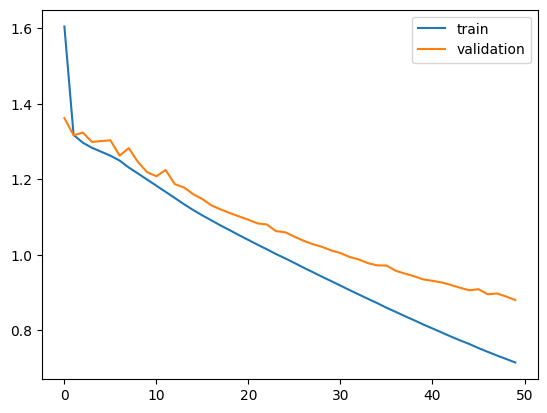

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

## Test Model

Finally, we can load the saved model and make predictions on the unseen data – testX.

In [43]:
# get 10 random ids of test samples
idx = random.randint(testX.shape[0], size=10)
# get 10 encoded english test samples
encoded_english_actual = testX[idx,:]
# get 10 actual english sentences 
eng_actual = test["english_sentances"].values
eng_actual = eng_actual[idx]
# get 10 actual telugu sentences
actual = test["telugu_sentances"].values
actual = actual[idx]

In [44]:
# load model weights
# model.load_weights(filepath)
# predict english sentence to telugu sentence
preds = model.predict(encoded_english_actual.reshape((encoded_english_actual.shape[0],encoded_english_actual.shape[1])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


These predictions are sequences of integers. We need to convert these integers to their corresponding words. Let’s define a function to do this:

In [45]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

Convert predictions into text (Telugu):

In [35]:
# preds_text = []
# for i in preds:
#     temp = []
#     for j in range(len(i)):
#         t = get_word(i[j], tel_tokenizer)
#         if j > 0:
#             if (t == get_word(i[j-1], tel_tokenizer)) or (t == None):
#                 temp.append('')
#             else:
#                 temp.append(t)
#         else:
#             if(t == None):
#                 temp.append('')
#             else:
#                 temp.append(t) 

#     preds_text.append(' '.join(temp))

Let’s create a dataframe with original english and telugu sentances and translated telugu sentences:

In [46]:
import numpy as np

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# Assuming you have a single tokenizer for both languages
# If you have separate tokenizers, replace 'tokenizer' with the appropriate one

# Predict
preds = model.predict(encoded_english_actual)

# If your model outputs probabilities, you might need to get the most likely token at each step
if preds.ndim == 3:  # (batch_size, sequence_length, vocab_size)
    preds = np.argmax(preds, axis=-1)

# Decode predictions
decoded_sentences = []
for pred in preds:
    sentence = []
    for token_index in pred:
        if token_index == 0:  # Assuming 0 is padding
            break
        word = get_word(token_index, tel_tokenizer)  # Use the same tokenizer here
        if word is not None:
            sentence.append(word)
    decoded_sentences.append(' '.join(sentence))

# Print some examples
for i in range(5):  # Print first 5 translations
    print(f"English: {' '.join([get_word(idx, eng_tokenizer) for idx in encoded_english_actual[i] if idx != 0])}")
    print(f"Predicted Telugu: {decoded_sentences[i]}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
English: tom walked his dog every day
Predicted Telugu: టామ్ తన తన తన చిత్రాన్ని

English: i did not tell my parents that i only got a c on my french test
Predicted Telugu: నేను నా నా నా కాని కాని

English: i would like to know why you did it
Predicted Telugu: మీరు ఎందుకు చేశారో నేను తెలుసుకోవాలి

English: tom often smiles
Predicted Telugu: టామ్ తరచుగా తరచుగా

English: who do you think she lives with
Predicted Telugu: ఆమె ఎవరితో అని మీరు అనుకుంటున్నారు



In [37]:
# pred_df = pd.DataFrame({'english_actual':eng_actual, 'telugu_actual' : actual, 'telugu_predicted' : preds_text})

In [38]:
# # print 10 rows
# pred_df.head(10)